In [4]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from IPython.display import display

import torch
import pandas as pd
from src.cogponder import CogPonderModel
from src.cogponder.data import NBackSRODataset, CogPonderDataModule
from pathlib import Path

In [5]:
# upon successful training, the model will be saved to this path
CHECKPOINT_PATH = Path('models/checkpoints/nback/cogponder_epochs-118.ckpt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# Load the dataset and configs

print('Loading N-Back dataset... ', end='')

max_epochs = 1000
batch_size = 1024
step_duration = 20

dataset = NBackSRODataset(n_subjects=1, n_back=2, step_duration=step_duration)
datamodule = CogPonderDataModule(dataset, batch_size=batch_size, num_workers=8)
datamodule.prepare_data()
# determine some parameters from data
n_subjects = torch.unique(dataset[:][0]).size(0)
n_contexts = torch.unique(dataset[:][2]).size(0)
n_features = dataset[:][3].size(-1)
n_outputs = torch.unique(dataset[:][4]).size(0)
max_response_step = dataset[:][5].max().int().item() + 1

# parameter space
configs = {
    'inputs_dim': n_features,
    'outputs_dim': n_outputs,
    'embeddings_dim': 2,
    'time_loss_beta': 1.,
    'learning_rate': 1e-2,
    'max_response_step': max_response_step,
    'n_contexts': n_contexts,
    'n_subjects': n_subjects,
    'subject_embeddings_dim': 2,
    'task': 'nback',
    'operator_type': 'spatiotemporal'
}

datamodule = CogPonderDataModule(dataset,
                                 batch_size=batch_size,
                                 num_workers=8)
datamodule.prepare_data()

print('Done!')

Loading N-Back dataset... Done!


In [22]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CHECKPOINT_PATH)

subject_ids, trial_ids, contexts, stimuli, y_human, rt_human, y_correct = datamodule.test_dataset[:]


with torch.no_grad():
    model_ckpt.eval()

    print('Predicting responses...', end='')
    y_pred, y_steps, p_halts, rt_pred = model_ckpt(stimuli, subject_ids, contexts)

    print('Done!')


Predicting responses...Done!


In [41]:
human_performance = pd.DataFrame({
    'condition': contexts.int(),
    'response_time': rt_human * dataset.step_duration,
    'accuracy': (y_correct == y_human).float() * 100,
    'agent': 'Human participant',
})

cogponder_performance = pd.DataFrame({
    'condition': contexts.int(),
    'response_time': rt_pred * dataset.step_duration,
    'accuracy': (y_correct == y_pred).float() * 100,
    'agent': 'CogPonder agent'
})

plot_data = pd.concat([human_performance,
                       cogponder_performance]).reset_index()

plot_data['response_time'] = plot_data['response_time'] / 1000.0  # to seconds

plot_data['condition'] = plot_data['condition'].map({True: 'Target', False: 'Non-target', -1: 'All'})

plot_data = plot_data.melt(value_vars=['accuracy', 'response_time'], id_vars=['condition', 'agent'])
plot_data['value'] = plot_data['value'].astype(float)

In [ ]:

g = sns.catplot(
    data=plot_data, x='condition', y='value', col='variable', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    # hue_order=['Human participant', 'CogPonder agent'], order=['All', 'Non-target', 'Target'],)
)
# g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('seconds')
g.axes[0,1].set_title('Response Time (sec)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)

# plt.suptitle('Comparing human (N=1) and CogPonder performance in the N-back task', y=1)
plt.savefig('outputs/figures/figure3-nback.png', dpi=300)
plt.show()

/Users/morteza/micromamba/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


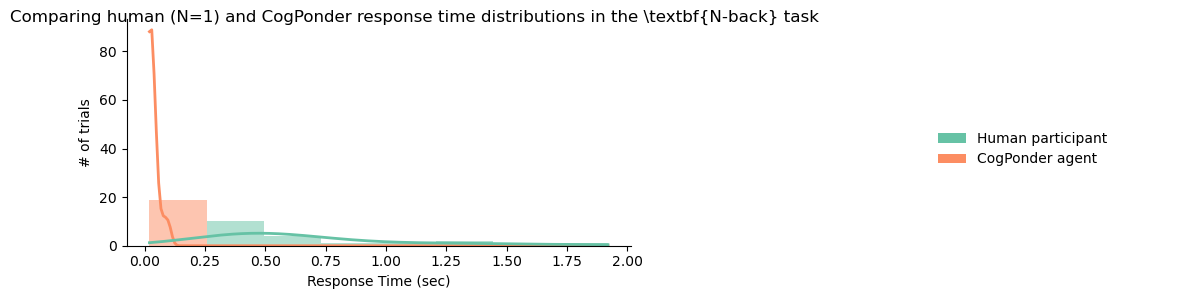

In [52]:
# Figure 4

plot_data = pd.DataFrame({
    'rt_true': rt_human * dataset.step_duration,
    'rt_pred': rt_pred * dataset.step_duration,
}).melt()

plot_data['value'] = plot_data['value'] / 1000.0  # to seconds

g = sns.displot(
    data=plot_data, x='value', hue='variable',
    kind='hist', kde=True, fill=True, common_norm=False,
    lw=0, alpha=.5, height=3, aspect=2,
    kde_kws={'cut': 0, 'clip': (0, 2000)},
    line_kws={'linewidth': 2},
    palette='Set2',
    hue_order=['rt_true', 'rt_pred'],
    legend=True
)

# replace labels
g._legend.set_title(None)
g.legend.set_bbox_to_anchor((1.6, .5))
for t, l in zip(g._legend.texts, ['Human participant', 'CogPonder agent']):
    t.set_text(l)

g._legend.legend_handles[0].set_alpha(1)
g._legend.legend_handles[1].set_alpha(1)

g.ax.set(xlabel='Response Time (sec)', ylabel='# of trials')

plt.suptitle('Comparing human (N=1) and CogPonder response time distributions in the \\textbf{N-back} task')
plt.savefig('outputs/figures/figure4-nback.png', dpi=300)
plt.show()